In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#Basic Imports
import os,sys
os.chdir("..")

from tqdm import tqdm,trange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import torch
import pandas

from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder

def plot_examples(images,labels,encoding, prediction=None):
    fig = plt.figure(figsize=(8, 5), dpi=150)
    for idx,img in enumerate(images[:32]):
        ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
        if np.max(img) > 1.5:
            img = img / 255
        plt.imshow(img)
        if prediction is not None:
            label = "GT: " + encoding[labels[idx]] + "\n PR: " + encoding[prediction[idx]]
        else:
            label = encoding[labels[idx]]    
        plt.title(str(label),fontsize=5)
        
def plot_cmatrix(pred,labels,encoding):
    fig = plt.figure(figsize=(8, 5), dpi=150)
    cm = confusion_matrix(labels,pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=encoding)
    disp.plot(xticks_rotation="vertical")

## Initialize parameters

In [2]:
path = "/scratch/fixmatch_results/nr_of_labels_supervised/eurosat_rgb"

In [3]:
checkpoints, args = get_model_checkpoints(path)
args = args[0]

In [4]:
args["batch_size"] = 256
args["data_dir"] = "./data/"
args["use_train_model"] = False
args["load_path"] = checkpoints[0]

## Eval

In [5]:
checkpoint_path = os.path.join(args["load_path"])
checkpoint = torch.load(checkpoint_path)
load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])

_net_builder = net_builder(args["net"],None,{})

net = _net_builder(num_classes=args["num_classes"])
net.load_state_dict(load_model)
if torch.cuda.is_available():
    net.cuda()
net.eval()

_eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
eval_dset = _eval_dset.get_dset()

eval_loader = get_data_loader(eval_dset, args["batch_size"], num_workers=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Using not pretrained model efficientnet-b2 ...


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


## Evaluate

In [6]:
label_encoding = _eval_dset.label_encoding
inv_transf = _eval_dset.inv_transform

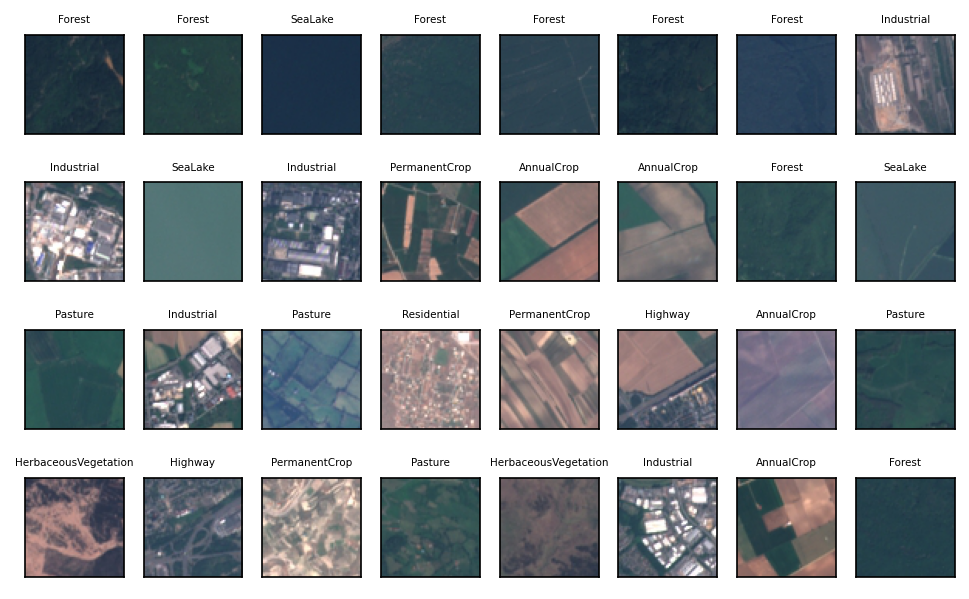

In [7]:
plot_examples(eval_dset.data,eval_dset.targets,label_encoding)

In [8]:
#Assemble a batch
images, labels, preds = [],[],[]
with torch.no_grad():
    for image, target in tqdm(eval_loader):
        image = image.type(torch.FloatTensor).cuda()
        logit = net(image)
        for idx,img in enumerate(image):
            images.append(inv_transf(img.transpose(0,2).cpu().numpy()).transpose(0,2).numpy())
        preds.append(logit.cpu().max(1)[1])
        labels.append(target)
labels = torch.cat(labels).numpy()
preds = torch.cat(preds).numpy()


100%|██████████| 11/11 [00:01<00:00,  8.66it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

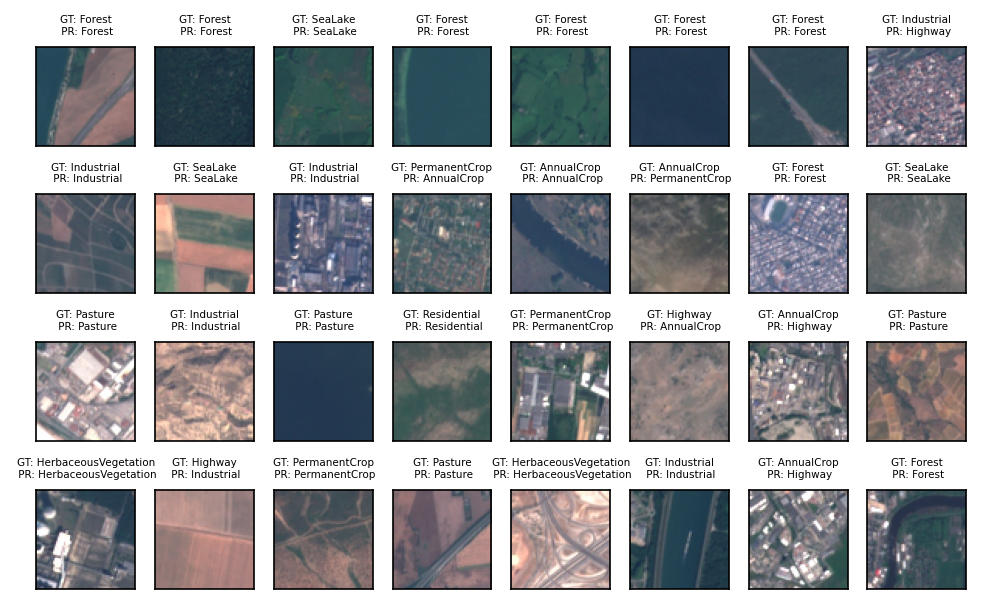

In [9]:
plot_examples(images[32:],labels,label_encoding,preds)

## Evaluate all training data

In [10]:
train_report = classification_report(labels, preds, target_names=label_encoding, output_dict=True)
print(classification_report(labels, preds, target_names=label_encoding))

                      precision    recall  f1-score   support

          AnnualCrop       0.80      0.58      0.67       300
              Forest       0.86      0.85      0.85       300
HerbaceousVegetation       0.61      0.63      0.62       300
             Highway       0.54      0.53      0.54       250
          Industrial       0.77      0.91      0.83       250
             Pasture       0.52      0.73      0.61       200
       PermanentCrop       0.52      0.54      0.53       250
         Residential       0.82      0.87      0.84       300
               River       0.58      0.52      0.55       250
             SeaLake       0.92      0.77      0.84       300

            accuracy                           0.70      2700
           macro avg       0.69      0.69      0.69      2700
        weighted avg       0.71      0.70      0.70      2700



<Figure size 1200x750 with 0 Axes>

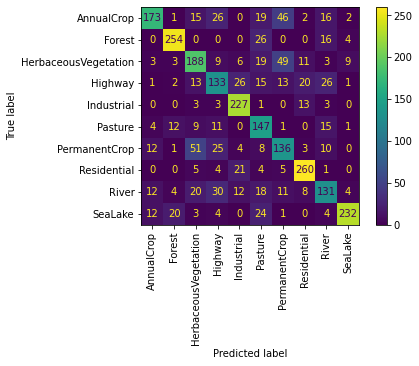

In [11]:
plot_cmatrix(preds,labels,label_encoding)

In [13]:
#Store results in a file
import pandas as pd
test_frame = pd.DataFrame(test_rtrain_reporteport).transpose()

In [14]:
test_frame.to_csv(FLAGS.ckpt + "_test_results.csv")

NameError: name 'FLAGS' is not defined